In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
properati = pd.read_csv('datos/properati_final.csv',index_col=0,error_bad_lines=False)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
from sklearn import preprocessing

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

le_region = preprocessing.LabelEncoder() 
regiones=properati['state_name']
le_region.fit(regiones)
properati['state_name'] = le_region.transform(regiones)

le_barrio = preprocessing.LabelEncoder()
barrios=properati['place_name']
le_barrio.fit(barrios)
properati['place_name'] = le_barrio.transform(barrios)

In [3]:
properati

,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,fecha,superficie_descubierta
created_on,,,,,,,,,,,,,,,,,,,,,
2015-07-01,1,324,3,"('-34.5745944268,-58.4192548517',)",-34.574594,-58.419255,71000.0,USD,1.252760e+06,71000.0,...,2448.0,43198.000000,NaN,1.0,1500.0,http://www.properati.com.ar/rlpn_venta_departa...,VENTA DEPARTAMENTO DE 1 AMBIENTE CON PATIO EN ...,Departamento en Palermo,"(2015, 7)",NaN
2015-07-01,2,264,2,"(nan,)",NaN,NaN,140000.0,USD,2.470230e+06,140000.0,...,NaN,756.756757,NaN,NaN,NaN,http://www.properati.com.ar/rlq6_venta_casa_lanus,None- Estado del inmueble: EXCELENTE- Mejoras:...,.,"(2015, 7)",NaN
2015-07-01,2,407,2,"('-34.7890466,-58.4135609',)",-34.789047,-58.413561,165000.0,USD,2.911342e+06,165000.0,...,NaN,825.000000,NaN,NaN,NaN,http://www.properati.com.ar/rlq7_venta_casa_te...,"Muy buen Chalet, a 2 cuadras e Hipermeracado J...",Casa en Temperley Oeste,"(2015, 7)",NaN
2015-07-01,2,275,2,"('-34.7507803881,-58.3734663672',)",-34.750780,-58.373466,148000.0,USD,2.611386e+06,148000.0,...,NaN,596.774194,NaN,NaN,NaN,http://www.properati.com.ar/rlq9_venta_casa_lo...,None- Estado del inmueble: REGULAR- Tiene gara...,Casa en Lomas de Zamora Oeste,"(2015, 7)",NaN
2015-07-01,1,407,2,"(nan,)",NaN,NaN,132000.0,USD,2.329074e+06,132000.0,...,1178.0,20795.000000,NaN,NaN,270.0,http://www.properati.com.ar/rlqa_venta_departa...,"Muy buen departamento; sobre avenida, a 6 cuad...",Departamento en Temperley Este,"(2015, 7)",NaN
2015-07-01,1,275,2,"('-34.7620958,-58.3998013',)",-34.762096,-58.399801,190000.0,USD,3.352455e+06,190000.0,...,1979.0,34921.000000,NaN,NaN,650.0,http://www.properati.com.ar/rlqb_venta_departa...,--Exclusivo Departamento de 3 Dormitorios--Tot...,Departamento en Lomas de Zamora Oeste,"(2015, 7)",6.0
2015-07-01,2,26,2,"('-34.7484869,-58.4011536',)",-34.748487,-58.401154,250000.0,USD,4.411125e+06,250000.0,...,NaN,1470.588235,NaN,NaN,NaN,http://www.properati.com.ar/rlqd_venta_casa_ba...,"Hermoso Chalet en excelente zona residencial, ...",Casa en Banfield Oeste,"(2015, 7)",NaN
2015-07-01,1,275,2,"('-34.7598575143,-58.4009207037',)",-34.759858,-58.400921,119000.0,USD,2.099696e+06,119000.0,...,1252.0,22102.000000,NaN,NaN,1500.0,http://www.properati.com.ar/rlqe_venta_departa...,"Muy buen departamento al frente, amplios ambie...",Oportunidad,"(2015, 7)",8.0
2015-07-01,3,407,2,"('-34.7791545891,-58.402501963',)",-34.779155,-58.402502,98000.0,USD,1.729161e+06,98000.0,...,2279.0,40213.000000,NaN,NaN,NaN,http://www.properati.com.ar/rlqf_venta_local_t...,Actualmente Alquilado.- Superficie cubierta su...,Local en Esquina,"(2015, 7)",43.0


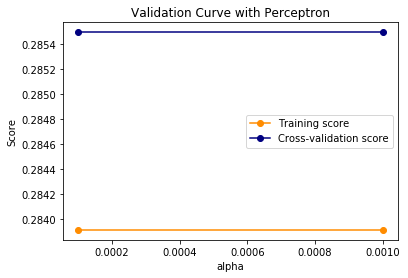

In [5]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import validation_curve
from matplotlib.mlab import frange
import matplotlib.pyplot as plt

#preparo set de datos
X = zip(properati['place_name'],properati['place_name'])
y = properati['state_name']

#param_range=frange(0.0001,0.0010,0.0001)
param_range=(0.0001,0.001)
train_scores, test_scores = validation_curve(
Perceptron(), X, y, param_name="alpha",param_range=param_range,
cv=5 ,n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.title("Validation Curve with Perceptron")
plt.xlabel("alpha")
plt.ylabel("Score")

plt.plot(param_range, train_scores_mean, label="Training score",
color="darkorange",marker="o")
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
color="navy",marker="o")

plt.legend(loc="best")
plt.show()

In [22]:
import numpy as np
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits

from sklearn.metrics import jaccard_similarity_score
from matplotlib.mlab import frange

#preparo set de datos
X = zip(properati['place_name'],properati['place_name'])
y = properati['state_name']

perceptron = Perceptron(n_jobs=-1)
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score: {0:.3f} (std: {1:.3f})".format(
                results['mean_train_score'][candidate],
                results['std_train_score'][candidate]))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
        
alpha=frange(0.0001,0.0100,0.001)
pen =['l2','l1','elasticnet',None]
param_grid = {"alpha": alpha, "penalty": pen}
grid_search = GridSearchCV(perceptron,param_grid=param_grid,cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 64.16 seconds for 44 candidate parameter settings.
Model with rank: 1
Mean training score: 0.380 (std: 0.021)
Mean validation score: 0.382 (std: 0.019)
Parameters: {'penalty': 'l2', 'alpha': 0.0011000000000000001}

Model with rank: 1
Mean training score: 0.380 (std: 0.021)
Mean validation score: 0.382 (std: 0.019)
Parameters: {'penalty': 'elasticnet', 'alpha': 0.0011000000000000001}

Model with rank: 3
Mean training score: 0.376 (std: 0.027)
Mean validation score: 0.376 (std: 0.029)
Parameters: {'penalty': 'l1', 'alpha': 0.0051000000000000004}

Model with rank: 4
Mean training score: 0.374 (std: 0.025)
Mean validation score: 0.374 (std: 0.026)
Parameters: {'penalty': 'l2', 'alpha': 0.0030999999999999999}

Model with rank: 4
Mean training score: 0.374 (std: 0.025)
Mean validation score: 0.374 (std: 0.026)
Parameters: {'penalty': 'elasticnet', 'alpha': 0.0030999999999999999}

Model with rank: 6
Mean training score: 0.371 (std: 0.025)
Mean validation score: 0.372 (std: 0